In [41]:
import networkx as nx
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, shape
import json
import matplotlib.pyplot as plt

import random
from utils import get_osrm_distance

years = [2009, 2010, 2011]
graphs = {}

for year in years:
    file_name = f"network_graphs_save/network_{year}_100.graphml"
    graphs[year] = nx.read_graphml(file_name)


In [42]:
def calculate_metrics(graph):
    metrics = {}

    # Calcolo delle metriche di base
    metrics["density"] = nx.density(graph)
    metrics["average_distance"] = np.mean([edge[2]['weight'] for edge in graph.edges(data=True)]) / 1000  # Converti in km
    metrics["diameter"] = nx.diameter(graph, e=None, usebounds=False)
    metrics["average_clustering"] = nx.average_clustering(graph)

    # Calcolo delle metriche di centralità
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)

    metrics["average_degree_centrality"] = np.mean(list(degree_centrality.values()))
    metrics["average_closeness_centrality"] = np.mean(list(closeness_centrality.values()))
    metrics["average_betweenness_centrality"] = np.mean(list(betweenness_centrality.values()))

    return metrics

def weighted_mean(values, weights):
    return sum(value * weight for value, weight in zip(values, weights)) / sum(weights)

results = []
for year in years:
    graph = graphs[year]
    components = [graph.subgraph(cc) for cc in nx.connected_components(graph) if len(cc) >= 2]

    metric_sums = {"density": 0.0, "average_distance": 0.0, "diameter": 0, "average_clustering": 0.0,
                   "average_degree_centrality": 0.0, "average_closeness_centrality": 0.0, "average_betweenness_centrality": 0.0}
    total_weight = 0
    subnetwork_sizes = []
    for component in components:
        metrics = calculate_metrics(component)
        weight = component.number_of_nodes()
        total_weight += weight
        for metric, value in metrics.items():
            metric_sums[metric] += value * weight
        subnetwork_sizes.append(weight)

    weighted_metrics = {metric: value / total_weight for metric, value in metric_sums.items()}
    weighted_metrics["year"] = year
    weighted_metrics["total_nodes"] = graph.number_of_nodes()
    weighted_metrics["subnetwork_sizes"] = subnetwork_sizes
    results.append(weighted_metrics)

df = pd.DataFrame(results)
df.head(10)



,density,average_distance,diameter,average_clustering,average_degree_centrality,average_closeness_centrality,average_betweenness_centrality,year,total_nodes,subnetwork_sizes
0,1.000000,19.034945,1.000000,0.929825,1.000000,1.000000,0.000000,2009,60,"[2, 2, 23, 4, 26]"
1,0.554777,33.468558,6.215385,0.841200,0.554777,0.614668,0.025106,2010,131,"[14, 2, 76, 38]"
2,0.369844,41.874592,11.448598,0.854503,0.369844,0.418840,0.009400,2011,324,"[258, 61, 2]"


C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


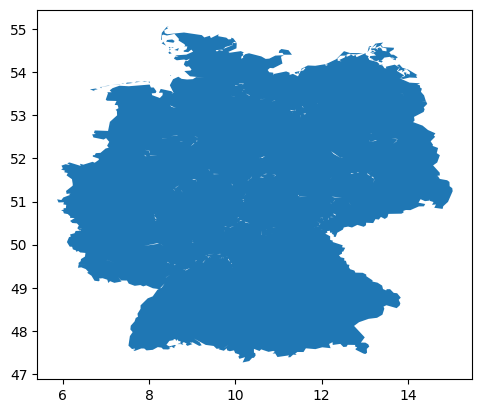

In [43]:
# Assumendo che germany_boundary sia già definito come segue:
germany_boundary = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/4090d4e1f89c1184b436b3d9ccaf332b4c5b43d2/2_bundeslaender/4_niedrig.geo.json')

# Crea un poligono unico dai confini dei Bundesländer
germany_polygon = germany_boundary.geometry.unary_union

# Crea un GeoDataFrame con il poligono unico
germany_gdf = gpd.GeoDataFrame(geometry=[germany_polygon])

# Plotta il GeoDataFrame
germany_gdf.plot()
plt.show()

In [44]:
def genetic_algorithm(graph, population_size=100, num_generations=100, mutation_rate=0.1, num_new_stations=50):

    def generate_initial_population(graph, population_size, num_new_stations, germany_polygon):
        min_lat = min(node_data['latitude'] for _, node_data in graph.nodes(data=True))
        max_lat = max(node_data['latitude'] for _, node_data in graph.nodes(data=True))
        min_lon = min(node_data['longitude'] for _, node_data in graph.nodes(data=True))
        max_lon = max(node_data['longitude'] for _, node_data in graph.nodes(data=True))

        population = []
        for _ in range(population_size):
            new_stations = []
            for _ in range(num_new_stations):
                lat, lon = random.uniform(min_lat, max_lat), random.uniform(min_lon, max_lon)
                new_point = Point(lat, lon)

                while not germany_polygon.contains(new_point):
                    lat, lon = random.uniform(min_lat, max_lat), random.uniform(min_lon, max_lon)
                    new_point = Point(lat, lon)

                new_stations.append((lat, lon))
            population.append(new_stations)
        return population
    
    def add_node_to_graph(graph, new_node_coordinates, max_distance):
        # Aggiungi il nuovo nodo al grafo
        new_node_id = len(graph) + 1
        lat, lon = new_node_coordinates
        graph.add_node(new_node_id, latitude=lat, longitude=lon)

        # Calcola la distanza tra il nuovo nodo e tutti gli altri nodi e aggiungi un arco se la distanza è inferiore a max_distance
        for node_id in graph.nodes:
            if node_id != new_node_id:
                lat1, lon1 = new_node_coordinates
                lat2, lon2 = graph.nodes[node_id]["latitude"], graph.nodes[node_id]["longitude"]
                distance = get_osrm_distance(lat1, lon1, lat2, lon2)
                if distance is not None and distance < max_distance * 1000:  # Converti max_distance in metri
                    graph.add_edge(new_node_id, node_id, weight=distance)
        return graph


    def fitness_function(solution, graph, max_distance=100):
        # Aggiungi i nuovi nodi al grafo
        updated_graph = graph.copy()
        for new_node_coordinates in solution:
            updated_graph = add_node_to_graph(updated_graph, new_node_coordinates, max_distance)

        # Calcola le metriche del grafo aggiornato
        metrics = calculate_metrics(updated_graph)

        weights = [0.5, 0.3, 0.2]  # Ad esempio, pesi per average_distance, diameter e average_clustering
        values = [metrics["average_distance"], metrics["diameter"], metrics["average_clustering"]]
        fitness = weighted_mean(values, weights)
        return fitness
    

    # Crossover a un punto
    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    # Mutazione
    def mutate(solution, mutation_rate, existing_nodes, germany_polygon):
        for i in range(len(solution)):
            if random.random() < mutation_rate:
                lat, lon = solution[i]
                new_point = Point(lat + random.uniform(-0.01, 0.01), lon + random.uniform(-0.01, 0.01))

                while not germany_polygon.contains(new_point):
                    new_point = Point(lat + random.uniform(-0.01, 0.01), lon + random.uniform(-0.01, 0.01))

                solution[i] = (new_point.x, new_point.y)
        return solution

    # min_lat = min(node_data['latitude'] for _, node_data in graph.nodes(data=True))
    # max_lat = max(node_data['latitude'] for _, node_data in graph.nodes(data=True))
    # min_lon = min(node_data['longitude'] for _, node_data in graph.nodes(data=True))
    # max_lon = max(node_data['longitude'] for _, node_data in graph.nodes(data=True))

    # population = [[(random.uniform(min_lat, max_lat), random.uniform(min_lon, max_lon)) for _ in range(num_new_stations)] for _ in range(population_size)]

    # Import the germany_polygon variable here
    population = generate_initial_population(graph, population_size, num_new_stations, germany_polygon)

    for generation in range(num_generations):
        # Calcola la fitness per ogni soluzione nella popolazione
        fitness_values = [fitness_function(solution, graph) for solution in population]

        # Seleziona i genitori per il crossover
        parents = random.choices(population, weights=fitness_values, k=population_size)

        # Esegui il crossover e la mutazione
        new_population = []
        for i in range(0, population_size, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            child1, child2 = crossover(parent1, parent2)
            # child1 = mutate(child1, mutation_rate)
            # child2 = mutate(child2, mutation_rate)
            # Pass the germany_polygon variable to mutate
            child1 = mutate(child1, mutation_rate, list(graph.nodes), germany_polygon)
            child2 = mutate(child2, mutation_rate, list(graph.nodes), germany_polygon)
            new_population.append(child1)
            new_population.append(child2)

        # Aggiorna la popolazione
        population = new_population

    # Trova la migliore soluzione nella popolazione finale
    best_solution = max(population, key=lambda x: fitness_function(x, graph))

    # Aggiungi le nuove stazioni al grafo originale e restituisci il grafo ottimizzato
    for new_node_coordinates in best_solution:
        graph = add_node_to_graph(graph, new_node_coordinates, max_distance=100)

    return graph


In [45]:
network_ottimizzato = genetic_algorithm(graphs[2009], num_new_stations=20, num_generations=10)

KeyboardInterrupt: 

In [ ]:
components = [network_ottimizzato.subgraph(cc) for cc in nx.connected_components(network_ottimizzato) if len(cc) >= 2]

metric_sums = {"density": 0.0, "average_distance": 0.0, "diameter": 0, "average_clustering": 0.0,
               "average_degree_centrality": 0.0, "average_closeness_centrality": 0.0, "average_betweenness_centrality": 0.0}
total_weight = 0
subnetwork_sizes = []
for component in components:
    metrics = calculate_metrics(component)
    weight = component.number_of_nodes()
    total_weight += weight
    for metric, value in metrics.items():
        metric_sums[metric] += value * weight
    subnetwork_sizes.append(weight)

weighted_metrics = {metric: value / total_weight for metric, value in metric_sums.items()}
weighted_metrics["total_nodes"] = network_ottimizzato.number_of_nodes()
weighted_metrics["subnetwork_sizes"] = subnetwork_sizes
print("Metriche pesate del grafo ottimizzato:", weighted_metrics)


Metriche pesate del grafo ottimizzato: {'density': 1.0, 'average_distance': 19.034944956937803, 'diameter': 1.0, 'average_clustering': 0.9298245614035088, 'average_degree_centrality': 1.0, 'average_closeness_centrality': 1.0, 'average_betweenness_centrality': 0.0, 'total_nodes': 60, 'subnetwork_sizes': [2, 2, 23, 4, 26]}


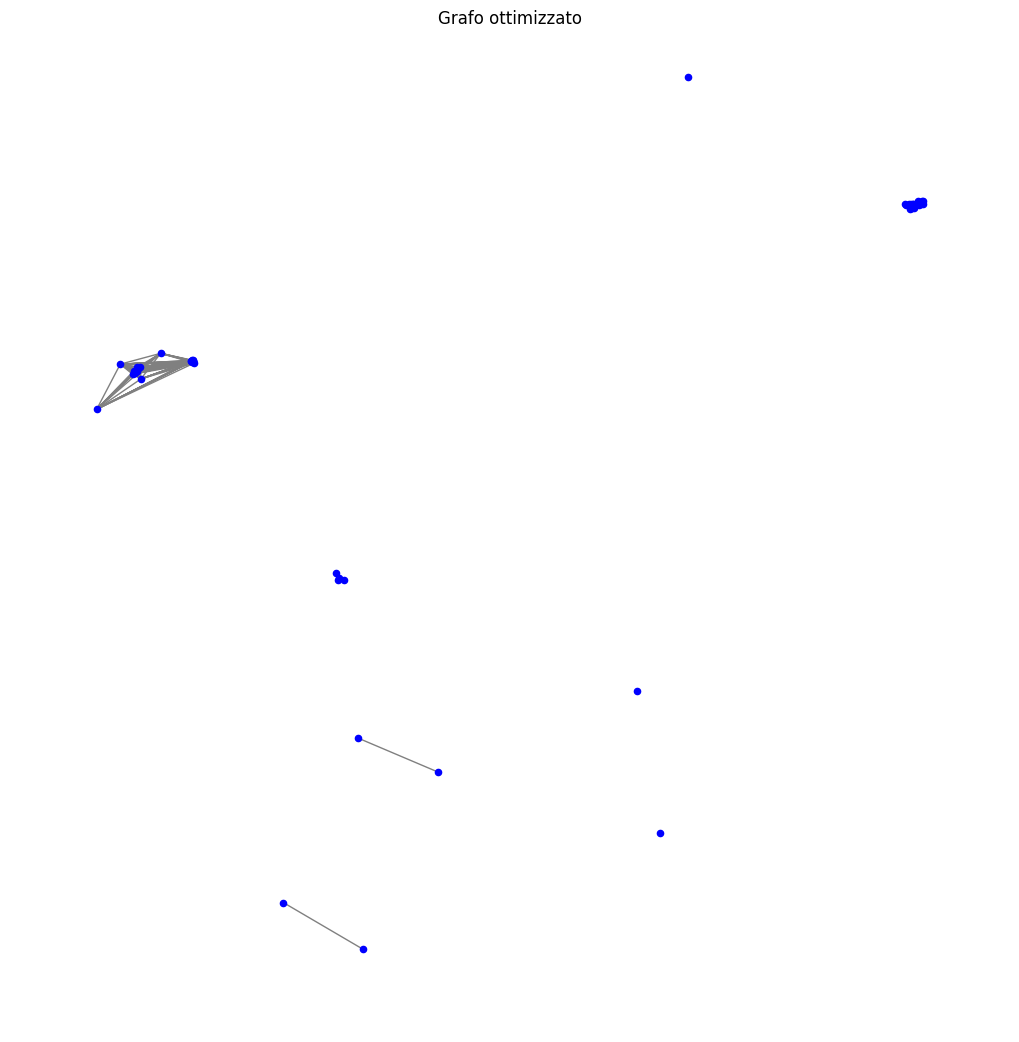

In [ ]:
import matplotlib.pyplot as plt

pos = {node_id: (node_data['longitude'], node_data['latitude']) for node_id, node_data in network_ottimizzato.nodes(data=True)}

plt.figure(figsize=(10, 10))
nx.draw(network_ottimizzato, pos, node_size=20, node_color='blue', edge_color='gray', with_labels=False)
plt.title('Grafo ottimizzato')
plt.show()